In [54]:
filePath = @__FILE__
workdir = dirname(filePath)
waterlilypath = dirname(dirname(workdir))*"/src/WaterLily.jl"

include(waterlilypath)
WaterLily = Main.WaterLily;
using Plots; gr()
using StaticArrays
using JLD2
using Images
using FFTW
using Statistics
using Interpolations
using DelimitedFiles
using LinearAlgebra

In [55]:
inside(a::AbstractArray) = CartesianIndices(map(ax->first(ax)+1:last(ax)-1,axes(a)))
@inline CI(a...) = CartesianIndex(a...)
"""
    δ(i,N::Int)
    δ(i,I::CartesianIndex{N}) where {N}

Return a CartesianIndex of dimension `N` which is one at index `i` and zero elsewhere.
"""
δ(i,::Val{N}) where N = CI(ntuple(j -> j==i ? 1 : 0, N))
δ(i,I::CartesianIndex{N}) where N = δ(i, Val{N}())


δ (generic function with 2 methods)

In [56]:
N = 32
computationID = "BubbleMove"*string(N)

"BubbleMove32"

In [57]:
lx = ((1:N).-0.5)/N
ly = ((1:N).-0.5)/N

function hydroDynP!(sim)
    ρ = sim.inter.f[2:end-1,2:end-1]*(1-sim.inter.λρ).+sim.inter.λρ
    cumsumρ = cumsum(ρ,dims=2)
    sumρ = sum(ρ,dims=2)
    cumsumρ = sumρ .- cumsumρ 
    sim.flow.σ[2:end-1,2:end-1] .= ((sim.flow.p[2:end-1,2:end-1]+sim.flow.p[2:end-1,1:end-2])/2 + cumsumρ*sim.flow.g[2])/(0.5sim.U^2)
end

function flood(f::Array;shift=(0.,0.),cfill=:RdBu_11,clims=(),levels=10,kv...)
    if length(clims)==2
        @assert clims[1]<clims[2]
        @. f=min(clims[2],max(clims[1],f))
    else
        clims = (minimum(f),maximum(f))
    end
    Plots.contourf(axes(f,1).+shift[1],axes(f,2).+shift[2],f',
        linewidth=0, levels=levels, color=cfill, clims = clims, 
        aspect_ratio=:equal; kv...)
    Plots.contour!(axes(f,1).+shift[1],axes(f,2).+shift[2],f',
        linewidth=2, levels=[0.5], color=:black)
end

addbody(x,y;c=:black) = Plots.plot!(Shape(x,y), c=c, legend=false)
function body_plot!(sim;levels=[0],lines=:black,R=inside(sim.flow.p))
    WaterLily.measure_sdf!(sim.flow.σ,sim.body,WaterLily.time(sim))
    Plots.contour!(sim.flow.σ[R]';levels,lines)
end

body_plot! (generic function with 1 method)

In [58]:
function sim_gif!(sim;duration=1,step=0.1,verbose=true,R=inside(sim.flow.p),
                    remeasure=false,plotbody=false,kv...)
    t₀ = round(WaterLily.sim_time(sim))
    for I∈inside(sim.flow.σ)
        sim.flow.σ[I] = WaterLily.div(I,sim.flow.u)
    end

    diver = [Statistics.sum(abs.(sim.flow.σ[R]))]
    mass = [Statistics.mean(sim.inter.f[R])]
    maxU = [maximum(sqrt.(Statistics.sum(sim.flow.u.^2,dims=4)))]
    trueTime = [WaterLily.time(sim)]
    @time anim = @animate for tᵢ in range(t₀,t₀+duration;step)
    # @time for tᵢ in range(t₀,t₀+duration;step)
        try
            WaterLily.sim_step!(sim,tᵢ;remeasure)
        catch y
            println(y)
            return diver,mass,maxU
        end
        for I∈inside(sim.flow.σ)
            sim.flow.σ[I] = WaterLily.div(I,sim.flow.u)
        end
        push!(diver,maximum(abs.(sim.inter.f[R].*sim.flow.σ[R])))
        push!(mass,Statistics.mean(sim.inter.f[R]))
        push!(maxU,maximum(sqrt.(Statistics.sum(sim.flow.u.^2,dims=4))))
        push!(trueTime,WaterLily.time(sim))
        Plots.contourf(lx.-0.5/N,ly,sim.flow.u[2:end-1,2:end-1,1]',color=:RdBu,levels=10,linewidth=0.0)
        Plots.contour!(lx,ly,sim.inter.f[2:end-1,2:end-1]', aspect_ratio=:equal,color=:Black,levels=[0.5],xlimit=[0,1],ylimit=[0,1],linewidth=2)
        plotbody && body_plot!(sim)
        verbose && println("tU/L=",round(tᵢ,digits=4),
            ", Δt=",sim.flow.Δt[end])
    end
    gif(anim, computationID*"_Velocity.gif", fps = 30)
    return diver,mass,maxU,trueTime
end


sim_gif! (generic function with 1 method)

In [59]:
function MovingBubble(NN;Re=500,g=9.81)
    LDomain = (NN,NN)
    R = NN/4
    LScale = R
    UScale = 1
    ν = UScale*LScale/Re

    function interSDF(xx)
        x,y = @. xx-1.5
        return ((x-NN/2)^2+(y-NN/2)^2)^0.5 - R
    end

    return WaterLily.TwoPhaseSimulation(LDomain, (0,0), LScale;U=UScale, Δt=0.01,grav=(0,-g), ν=ν, InterfaceSDF=interSDF, T=Float64,λν=1,λρ=1e-3,perdir=(1,),uλ=(i,x) -> ifelse(i==1,1,0))
end


MovingBubble (generic function with 1 method)

In [60]:
sim = MovingBubble(N, Re=1000, g=0.0)

Main.WaterLily.TwoPhaseSimulation(1, 8.0, 1, Main.WaterLily.Flow{2, Float64, Matrix{Float64}, Array{Float64, 3}, Array{Float64, 4}}([1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; -0.0 0.0 … 0.0 -0.0; -0.0 0.0 … 0.0 -0.0; … ; -0.0 0.0 … 0.0 -0.0; -0.0 0.0 … 0.0 -0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; …

In [61]:
minimum(sim.flow.u[:,:,1])

1.0

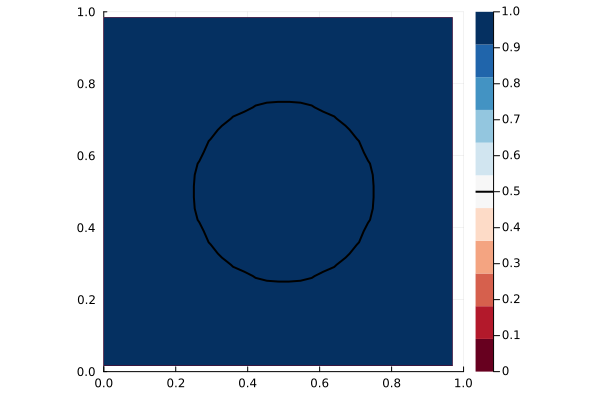

In [69]:
Plots.contourf(lx.-0.5/N,ly,sim.flow.u⁰[2:end-1,2:end-1,1]',color=:RdBu,levels=10,linewidth=0.0)
Plots.contour!(lx,ly,sim.inter.f[2:end-1,2:end-1]', aspect_ratio=:equal,color=:Black,levels=[0.5],xlimit=[0,1],ylimit=[0,1],linewidth=2)

In [63]:
a,b,c,d = sim.flow, sim.pois, sim.inter, sim.body

(Main.WaterLily.Flow{2, Float64, Matrix{Float64}, Array{Float64, 3}, Array{Float64, 4}}([1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; -0.0 0.0 … 0.0 -0.0; -0.0 0.0 … 0.0 -0.0; … ; -0.0 0.0 … 0.0 -0.0; -0.0 0.0 … 0.0 -0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [1

In [64]:
a.u⁰ .= a.u;
WaterLily.advect!(a,c,c.f,a.u⁰,a.u);

In [65]:
WaterLily.measure!(a,d;t=0,ϵ=1,perdir=a.perdir);

In [66]:
a.u .= 0;

In [67]:
WaterLily.vof_smooth!(2, c.f⁰, c.fᶠ, c.α;perdir=c.perdir)
WaterLily.conv_diff!(a.f,a.u⁰,a.σ,ν=(d,I)->a.ν*WaterLily.calculateρν(d,I,c.fᶠ,c.λν), perdir=a.perdir,g=a.g)

In [68]:
WaterLily.BDIM!(a);WaterLily.BCVecPerNeu!(a.u;Dirichlet=true, A=a.U, perdir=a.perdir) 

In [ ]:
WaterLily.calculateL!(a,c)
WaterLily.update!(b)

In [13]:
WaterLily.project!(a,b); 
WaterLily.BCVecPerNeu!(a.u;Dirichlet=true, A=a.U, perdir=a.perdir)

In [19]:
# replace!(sim.flow.u,NaN=>0);

In [ ]:

diver,mass,maxU,trueTime = sim_gif!(sim,duration=2, step=0.01,clims=(0,1),plotbody=false,verbose=true,levels=0.0:0.05:1.0,remeasure=false,cfill=:RdBu,linewidth=2,xlimit=[0,32],ylimit=[0,32],shift=(-0.5,-0.5));


In [ ]:

trueTime *= sim.U/sim.L
maxU /= sim.U

massrel = abs.((mass.-mass[1])/mass[1]).+1e-20
Plots.plot(trueTime,diver.+1e-20,yaxis=:log10,label="Velocity Divergence" ,color=:red)
Plots.plot!(trueTime,massrel,yaxis=:log10,label="Mass loss",color=:blue)
Plots.plot!(ylimit=[1e-10,1])
Plots.savefig(computationID*"_MassDivergence.png")

Plots.plot(trueTime,maxU)
Plots.savefig(computationID*"_MaxU.png")

aa = cumsum(sim.flow.Δt)[1:end-1]*sim.U/sim.L

Plots.plot(aa,sim.pois.res0[1:2:end],yscale=:log10,label="First Stage")
Plots.plot!(aa,sim.pois.res0[2:2:end],yscale=:log10,label="Second Stage",legend=:bottomleft)
Plots.savefig(computationID*"_PoisRes.png")

Plots.plot(aa,sim.pois.n[1:2:end],label="First Stage")
Plots.plot!(aa,sim.pois.n[2:2:end],label="Second Stage")
Plots.savefig(computationID*"_PoisNum.png")

Plots.plot(aa,sim.flow.Δt[1:end-1],ylimit=(0,0.05))
Plots.savefig(computationID*"_delT.png")

jldsave(computationID*"_VelVof.jld";sim.flow.u,sim.inter.f)


